## Building a GPT



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/chatgpt-vanilla"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/chatgpt-vanilla


## Dataset
The Tiny Shakespeare Dataset is a small dataset of English text that consists of selected works of William Shakespeare. The dataset includes a total of 1,115,394 characters from Shakespeare's plays.

The dataset was originally intended for use in training language models. It is often used as a benchmark dataset for testing and comparing different natural language processing (NLP) models.

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-01-17 01:39:27--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2023-01-17 01:39:28 (29.0 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
%ls

chatgpt-vanilla.ipynb  input.txt  Untitled0.ipynb


In [5]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [6]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### Data Preprocessing
Encoding is necessary for text data in order to convert it into a numerical format that can be processed by machine learning and deep learning models. Text data is typically represented as a sequence of characters or words, and in its raw form, it cannot be directly used as input to deep learning models.

In this part we decode text data using character-level mapping.
* `stoi` dictionary is a mapping from unigue characters to integers, where each character in a given set of characters is assigned a unique integer.

* `itos` dictionary is the inverse mapping(integers back to characters).

In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [8]:
stoi

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'B': 14,
 'C': 15,
 'D': 16,
 'E': 17,
 'F': 18,
 'G': 19,
 'H': 20,
 'I': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64}

Encode the entire dataset using the character-level encoding technique, and converting it to a PyTorch tensor.

In [9]:
import torch 
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      


Spliting up the data into train and validation datasets: **90%** for training and **10%** for validation

In [10]:
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

Block size is maximum context length for predictions which are given as inputs

In [11]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [12]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
x_ = decode([i.item() for i in x])
y_ = decode([i.item() for i in y])
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    context_txt = x_[:t+1]
    target_txt = y_[t]
    print(f"When the input is {context_txt}({context}) the target is {target_txt}({target})")
    print("----------------------------------------------------")

When the input is F(tensor([18])) the target is i(47)
----------------------------------------------------
When the input is Fi(tensor([18, 47])) the target is r(56)
----------------------------------------------------
When the input is Fir(tensor([18, 47, 56])) the target is s(57)
----------------------------------------------------
When the input is Firs(tensor([18, 47, 56, 57])) the target is t(58)
----------------------------------------------------
When the input is First(tensor([18, 47, 56, 57, 58])) the target is  (1)
----------------------------------------------------
When the input is First (tensor([18, 47, 56, 57, 58,  1])) the target is C(15)
----------------------------------------------------
When the input is First C(tensor([18, 47, 56, 57, 58,  1, 15])) the target is i(47)
----------------------------------------------------
When the input is First Ci(tensor([18, 47, 56, 57, 58,  1, 15, 47])) the target is t(58)
----------------------------------------------------


In [13]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [14]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


## Bigram language model
A bigram language model which is one of the simplest language models is a type of statistical language model that uses a simple approach to predict the probability of the next word in a sequence given the previous word. Specifically, it assumes that the probability of a word depends only on the previous word (i.e., it assumes a Markov process of order 1). Of course in this case character by character.

During generation, the model can be used to generate new sequences of text by repeatedly predicting the next token in the sequence based on the previous token. This is done by sampling from the probability distribution over the vocabulary generated by the softmax function applied to the logits produced by the model for the previous token. The resulting sequence of predicted tokens can be converted back into text using a decoder function that maps each integer token back to its corresponding character.
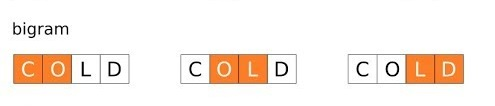


**Logits:**
In a bigram language model, logits are the output of the linear layer that computes the unnormalized scores for each possible next token in the sequence given the current token.

More specifically, given the current token (represented as an integer index), the embedding layer of the model maps it to a dense vector representation. This vector is then fed into the linear layer, which computes a score (logit) for each possible next token in the vocabulary. The logits are unnormalized because they have not yet been transformed into a probability distribution over the vocabulary. the logits are typically passed through a softmax function, which exponentiates each logit and normalizes the resulting values to sum to 1



## The theory of bigram model

A Bigram Model corresponds to a model which approximates the probability of a character($w_n$) given all the previous characters $P(w_n|w_{1:n−1})$ by using only the conditional probability of the preceding character $P(w_n|w_{n−1})$. Thus we assume that $P(w_n|w_{1:n−1}) ≈ P(w_n|w_{n−1})$. This approximation is known as the **Markov** approximation. Thus, for the Bigram model, the probability for an entire sequence can be approximated as:

$$\large
P(w_{1:n}) ≈ \prod_{k=1}^{n}P(w_{k}|w_{k−1}) 
$$



In [18]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # idx's are encoded inputs
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape # [B = batch size, T = block size, C = vocab_size] = [4, 8, 65] 
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([256, 65])
tensor(4.6677, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [19]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [20]:
batch_size = 32
# training the model 
for steps in range(500): # increase number of steps for good results... 
    
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


4.1035356521606445


In [21]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


AE!U;Ad,pLIMIFEsr.RdlaNXYGv
pxiE:ChimxhDWiNGMbl-QbWIMU'd&XcqAWWi!o'wBkb .xIBHYw:wos$O-WOd,iSBiTdegVb&q-oB-dd fqV&ogX&otKhcEQmD.oink,zLEbnYsB'pilgo.imU?w;.
Jm;zonP:VcxZvDIBTy&viqmJXc;AUDYwOl-IK?qPgRjFF&ynSq-wfxHM$zyatNHeRs$w?OM ?ERyi-wQQGXEoXI:gFo,iRyeyTbyhJGhhErkgOpvi.vETFZsEJOpxuMptu?uv'dLvxmfNQByA:CtLQv.boipuEQbH:wiqS&vqV3VJKbE,y;gXKpNXS?YwaxMmJhiW:vvXHqooI'ZhOc
ETvq,a!-UGJktlgd?nerWboXV&o!!$pmZA-w'VOLPjJsi.v.J!kgCL;i?n!

pJb
?sEBc Cjd CUzev!$ ft&Hw?EJXeh?ONbfiltKlxYulZpR;KHAVj?tROM:p fottkcL!


### What is Attention?
 the attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements’ keys. An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key. In particular, an attention mechanism has usually four parts we need to specify:

*   **Query:** The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.

*   **Keys:** For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is “offering”, or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.

*   **Values:** For each input element, we also have a value vector. This feature vector is the one we want to average over.

*   **Score function:** To rate which elements we want to pay attention to, we need to specify a score function 
. The score function takes the query and a key as input, and output the score/attention weight of the query-key pair. It is usually implemented by simple similarity metrics like a dot product, or a small MLP.

**Masking**\
self-attention layers in the decoder allow each position in the decoder to attend to
all positions in the decoder up to and including that position. We need to prevent leftward
information flow in the decoder to preserve the auto-regressive property. We implement this
inside of scaled dot-product attention by masking out (setting to −∞) all values in the input
of the softmax which correspond to illegal connections.

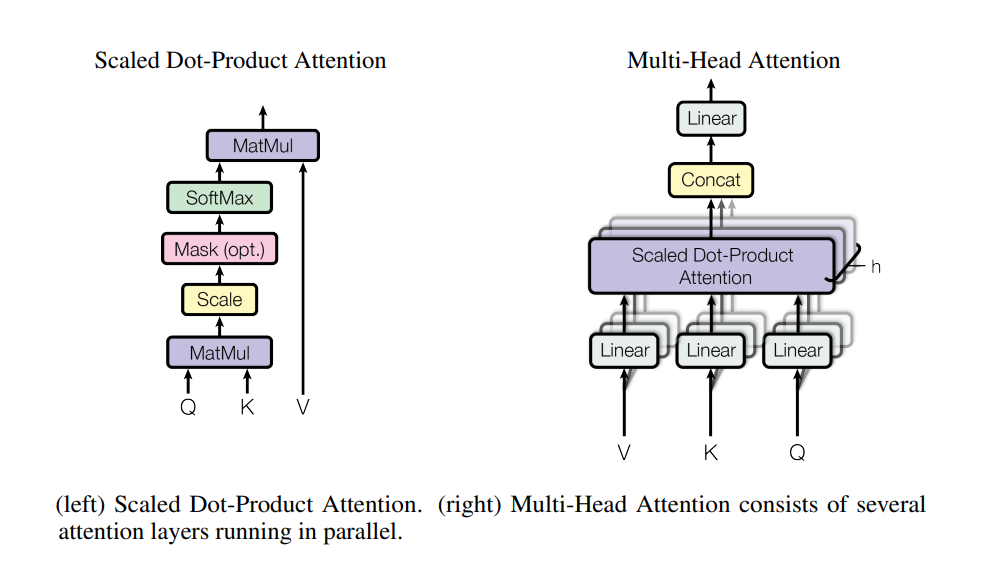

In the code below we use the `key` and `query` linear transformations to compute the attention weights. Then, compute the dot product between the `query` and `key` vectors for each pair of time steps in the sequence. The result is the attention weights for each time step.\
Then we create a lower triangular mask for the attention weights to ensure that each time step only attends to previous time steps. This is achieved by creating a matrix of ones and setting all elements above the main diagonal to zero. The resulting matrix is then negated and used as a mask to set attention weights for future time steps to negative infinity.

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

#masking the weights
tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

The masked weights are printed below

In [ ]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:

- "Scaled "Scaled Dot-Product Attention"  additional divides `wei` by 1/sqrt(head size).
$$Attention(Q, K, V ) = softmax(\frac{QK^{T}}{\sqrt{d_k}})V$$
This makes it so when input Q, K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.
$$MultiHead(Q, K, V ) = Concat(head1, ..., headh)W^O$$
$$where \ head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)$$

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

`LayerNorm1d` that performs layer normalization on 1-dimensional input tensor. In layer normalization, for each data point in the input tensor, the mean and variance are calculated along the features dimension (axis=1) rather than along the batch dimension (axis=0) as in batch normalization.

In [ ]:
class LayerNorm1d: # (used to be BatchNorm1d)
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

## Full finished code
Training and testing tranformer based bigram language model on GPU.

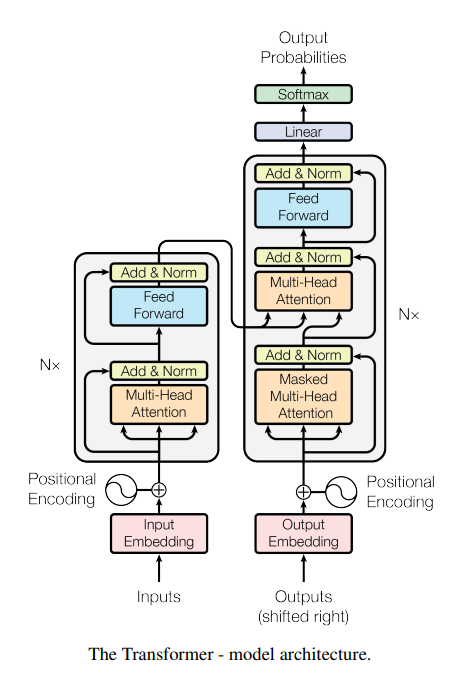

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm.notebook import  tqdm

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)# sa:self attenion
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses, val_losses=[],[]
for iter in tqdm(range(max_iters)):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


Running on cuda
0.209729 M parameters


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5091, val loss 2.5059
step 300: train loss 2.4196, val loss 2.4335
step 400: train loss 2.3503, val loss 2.3565
step 500: train loss 2.2967, val loss 2.3132
step 600: train loss 2.2411, val loss 2.2502
step 700: train loss 2.2064, val loss 2.2198
step 800: train loss 2.1640, val loss 2.1869
step 900: train loss 2.1243, val loss 2.1508
step 1000: train loss 2.1043, val loss 2.1310
step 1100: train loss 2.0689, val loss 2.1175
step 1200: train loss 2.0379, val loss 2.0791
step 1300: train loss 2.0243, val loss 2.0638
step 1400: train loss 1.9933, val loss 2.0365
step 1500: train loss 1.9700, val loss 2.0298
step 1600: train loss 1.9622, val loss 2.0463
step 1700: train loss 1.9410, val loss 2.0143
step 1800: train loss 1.9082, val loss 1.9951
step 1900: train loss 1.9115, val loss 1.9890
step 2000: train loss 1.8848, val loss 1.9934
step 2100: train loss 1.8711, val loss 1.9740


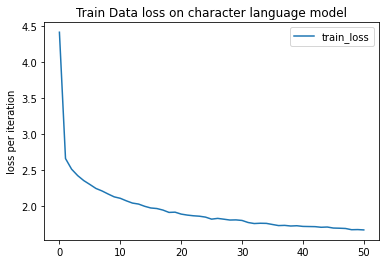

In [3]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train_loss')
plt.title('Train Data loss on character language model')
plt.ylabel('loss per iteration')
plt.legend()
plt.show()

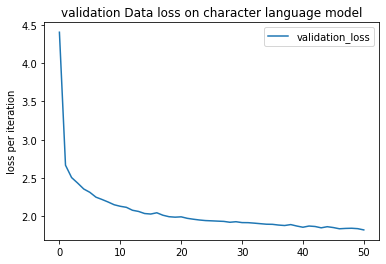

In [4]:
import matplotlib.pyplot as plt
plt.plot(val_losses, label='validation_loss')
plt.title('validation Data loss on character language model')
plt.ylabel('loss per iteration')
plt.legend()
plt.show()